### Описание проекта

В нашем распоряжении данные 500 пользователей комапании "Мегалайн" за 2018 год.

**Цель анализа:** определить наиболее выгодный тариф. 

**Примечание:**

   - «Мегалайн» всегда округляет секунды до минут 
   - мегабайты — до гигабайт. 
   - Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
   - Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Таблица `users_df` содержит данные о пользователях тарифов. В каждой строке у `user_id` есть информация о его возрасте, городе проживания, имя и фамилия, название используемого тарифа и 2 даты: дата регистрации тарифа и дата, когда пользователь ушел.
 
Описание столбцов таблицы:

- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица `calls_df` содержит данные о звонках пользователей из таблицы `users_df`. В каждой строке у `id` звонка есть информация о его дате и длительности. 

Описание столбцов таблицы `calls_df`

- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

В таблице собраны даты каждого сообщении пользователя. Каждому сообщению присвоен уникальный номер, он лежит в столбце`id`, а id пользователя лежит в солбце `user_id`

Описание столбцов таблицы `messages_df`
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

В таблице `internet_df` представлены данные о потребляемом трафике каждого пользователя. В каждой строке лежит информация об одной сессии с уникальным id, дата этой сессии и количество потраченных мегабайт

Описание столбцов таблицы `internet_df`:

- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица `tariffs_df` содержит данные о двух тарифах: **smart** и **ultra**. В таблице `users_df` есть информация, на каком тарифе пользователь. 

Информация о столбцах таблицы:
    
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


**Описание тарифов**

Тариф «Смарт»:
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»:
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from textwrap import dedent
from IPython import get_ipython
from scipy import stats as st
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', 50)

In [2]:
#загрузка данных
calls_df = pd.read_csv('calls.csv')
messages_df = pd.read_csv('messages.csv')
internet_df = pd.read_csv('internet.csv', index_col=0)
tariffs_df = pd.read_csv('tariffs.csv')
users_df = pd.read_csv('users.csv')

### Предобработка данных

In [3]:
dataframes = ['users_df', 'calls_df', 'messages_df', 'internet_df', 'tariffs_df']

In [4]:
def create_cell(shell, text):
    payload = dict(
        source='set_next_input',
        text=text,
        replace=False,
    )
    shell.payload_manager.write_payload(payload, single=False)

In [5]:
def generate_df_preprocess_description(df):
    shell = get_ipython()
    for i,df in reversed(list(enumerate(dataframes))):
        
        create_cell(shell, dedent(
            f'''
            print('Null or Na count is', {df}.isna().sum())
            
            '''
        ))
        create_cell(shell, dedent(
            f'''
            {df}.describe()
            '''
        ))
        create_cell(shell, dedent(
            f'''
            print("Количество дубликатов", {df}.duplicated().sum())
            '''
        ))
        create_cell(shell, dedent(
            f'''
            {df}.info()
            '''
        ))
        create_cell(shell, dedent(
            f'''
            display({df}.head())
            '''
        ))
        create_cell(shell, dedent(
            f'''
            #### {i+1}. Обработка "{df}"
            '''
        ))

In [6]:
#generate_df_preprocess_description(dataframes)


#### 1. Обработка "users_df"


In [7]:

display(users_df.head())


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:

users_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:

print("Количество дубликатов", users_df.duplicated().sum())


Количество дубликатов 0


In [10]:

users_df.describe()


,user_id,age
count,500.000,500.000
mean,1249.500,46.588
std,144.482,16.668
min,1000.000,18.000
25%,1124.750,32.000
50%,1249.500,46.000
75%,1374.250,62.000
max,1499.000,75.000


In [11]:

print('Null or Na count is', users_df.isna().sum())



Null or Na count is user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64



#### 2. Обработка "calls_df"


In [12]:

display(calls_df.head())


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


In [13]:

calls_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [14]:

print("Количество дубликатов", calls_df.duplicated().sum())


Количество дубликатов 0


In [15]:

calls_df.describe()


,duration,user_id
count,202607.000,202607.000
mean,6.756,1253.941
std,5.843,144.723
min,0.000,1000.000
25%,1.300,1126.000
50%,6.000,1260.000
75%,10.700,1379.000
max,38.000,1499.000


In [16]:

print('Null or Na count is', calls_df.isna().sum())



Null or Na count is id           0
call_date    0
duration     0
user_id      0
dtype: int64



#### 3. Обработка "messages_df"


In [17]:

display(messages_df.head())


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:

messages_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:

print("Количество дубликатов", messages_df.duplicated().sum())


Количество дубликатов 0


In [20]:

messages_df.describe()


,user_id
count,123036.000
mean,1256.989
std,143.524
min,1000.000
25%,1134.000
50%,1271.000
75%,1381.000
max,1499.000


In [21]:

print('Null or Na count is', messages_df.isna().sum())



Null or Na count is id              0
message_date    0
user_id         0
dtype: int64



#### 4. Обработка "internet_df"


In [22]:

display(internet_df.head())


,id,mb_used,session_date,user_id
0,1000_0,112.950,2018-11-25,1000
1,1000_1,1052.810,2018-09-07,1000
2,1000_2,1197.260,2018-06-25,1000
3,1000_3,550.270,2018-08-22,1000
4,1000_4,302.560,2018-09-24,1000


In [23]:

internet_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [24]:

print("Количество дубликатов", internet_df.duplicated().sum())


Количество дубликатов 0


In [25]:

internet_df.describe()


,mb_used,user_id
count,149396.000,149396.000
mean,370.192,1252.100
std,278.301,144.051
min,0.000,1000.000
25%,138.188,1130.000
50%,348.015,1251.000
75%,559.553,1380.000
max,1724.830,1499.000


In [26]:

print('Null or Na count is', internet_df.isna().sum())



Null or Na count is id              0
mb_used         0
session_date    0
user_id         0
dtype: int64



#### 5. Обработка "tariffs_df"


In [27]:

display(tariffs_df.head())


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [28]:

tariffs_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [29]:

print("Количество дубликатов", tariffs_df.duplicated().sum())


Количество дубликатов 0


In [30]:

tariffs_df.describe()


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000,2.000,2.000,2.000,2.000,2.000,2.000
mean,525.000,23040.000,1750.000,1250.000,175.000,2.000,2.000
std,671.751,10861.160,1767.767,989.949,35.355,1.414,1.414
min,50.000,15360.000,500.000,550.000,150.000,1.000,1.000
25%,287.500,19200.000,1125.000,900.000,162.500,1.500,1.500
50%,525.000,23040.000,1750.000,1250.000,175.000,2.000,2.000
75%,762.500,26880.000,2375.000,1600.000,187.500,2.500,2.500
max,1000.000,30720.000,3000.000,1950.000,200.000,3.000,3.000


In [31]:

print('Null or Na count is', tariffs_df.isna().sum())



Null or Na count is messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64


#### Вывод
   - нам предоставлены данные о 500 клиентах, которые пользуется двумя тарифами "Мегалайн" в течение 2018 года
   - мы проверили данные на дубликаты, пропуски. Дубликатов не нашлось, все пропуски обоснованы.
   - в таблице `users_df` в столбце `churn_date` пропуски означают, что пользователь ещё не расторг договор
   - данным в столбцах с датами требуется поменять тип для дальнейшей работы
   

### Исправим данные в таблицах `calls_df`, `messages_df` и `internet_df`

#### Исправим тип данных в столбцах с датой и добавим столбец с номером месяца

In [32]:
#перевод даты из строки в тип datetime64
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')

#добавим столбец с номером календарного месяца
calls_df['month'] = pd.DatetimeIndex(calls_df['call_date']).month

messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d')
messages_df['month'] = pd.DatetimeIndex(messages_df['message_date']).month

internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format='%Y-%m-%d')
internet_df['month'] = pd.DatetimeIndex(internet_df['session_date']).month

users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')
users_df['month_start'] = pd.DatetimeIndex(users_df['reg_date']).month
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], format='%Y-%m-%d')
users_df['month_end'] = pd.DatetimeIndex(users_df['churn_date']).month

In [33]:
calls_df.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.000,1000,7
1,1000_1,2018-08-17,0.000,1000,8
2,1000_2,2018-06-11,2.850,1000,6
3,1000_3,2018-09-21,13.800,1000,9
4,1000_4,2018-12-15,5.180,1000,12


In [34]:
messages_df.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [35]:
internet_df.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.950,2018-11-25,1000,11
1,1000_1,1052.810,2018-09-07,1000,9
2,1000_2,1197.260,2018-06-25,1000,6
3,1000_3,550.270,2018-08-22,1000,8
4,1000_4,302.560,2018-09-24,1000,9


In [36]:
users_df.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_end
483,1483,28,NaT,Ульяновск,Серафима,Борисова,2018-04-11,smart,4,NaN
129,1129,48,NaT,Курган,Анвар,Морозов,2018-12-17,smart,12,NaN
386,1386,21,NaT,Новосибирск,Фаддей,Родионов,2018-08-13,smart,8,NaN
226,1226,19,NaT,Новосибирск,Альбин,Бобылёв,2018-06-01,ultra,6,NaN
12,1012,38,NaT,Санкт-Петербург,Варлам,Соловьев,2018-03-28,smart,3,NaN


#### Вывод
   - в каждой таблице, где есть даты, заменили тип данных и добавили столбец с номером месяца.
   - теперь данные можно группировать по пользователям и месяцам
  

### Расчет агрегированных показателей

#### Найдём потраченные минуты у "calls_df"

In [37]:
#округлим секунды разговора до минут(в большую сторону)
calls_df['duration'] = np.ceil(calls_df['duration']).astype(int)

#### Количество сделанных звонков и их продолжительность по месяцам

In [38]:
calls_df_grouped = calls_df.groupby(['user_id', 'month'])['duration'].agg(['count','sum'])

calls_df_grouped = calls_df_grouped.rename(columns={'sum':'duration_per_month', 'count':'number_of_calls'}).sort_values(by='user_id', ascending = True).reset_index()

In [80]:
calls_df_grouped

,user_id,month,number_of_calls,duration_per_month
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
...,...,...,...,...
3169,1498,9,59,471
3170,1499,10,68,449
3171,1499,11,74,612
3172,1499,9,9,70


#### Гистограмма duration

count   202607.000
mean         7.158
std          5.959
min          0.000
25%          2.000
50%          6.000
75%         11.000
max         38.000
Name: duration, dtype: float64


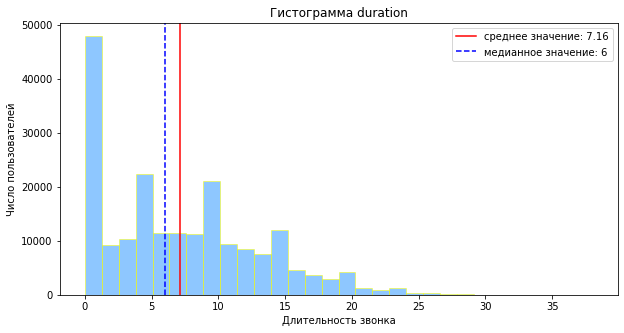

In [40]:
print(calls_df['duration'].describe())
plt.figure(figsize=(10,5))
plt.hist(calls_df['duration'], bins=30, color='dodgerblue', edgecolor='yellow', alpha=0.5)
plt.title("Гистограмма duration")
plt.xlabel("Длительность звонка")
plt.ylabel("Число пользователей")
plt.axvline(calls_df['duration'].describe()['mean'], color='r', label='среднее значение: {:.2f}'.format(calls_df['duration'].describe()['mean']))
plt.axvline(calls_df['duration'].describe()['50%'], color='b', linestyle='dashed', label='медианное значение: {:.0f}'.format(calls_df['duration'].describe()['50%']))
plt.legend()
plt.show()

#### Вывод

 - Нулями обозначены пропущенные звонки, поэтому их не нужно удалять. За пропущенные звонки не взимается плата, а при группировке они не будт влиять на результат.
 - Есть несколько пиков на 5, 10, 15 и 20 минутах, нужно уточнить у коллег, с чем связаны пики, воможно в тарифах есть звуковой сигнал после каждых пяти минут.
 - Среднее больше медианного из-за большого количество звонков длительностью 0 секунд. Максимальная дилительность звонка у абонентов обоих тарифов - 38 минут

#### Количество сообщений по месяцам

In [41]:
message_grouped = messages_df.groupby(['user_id','month']).agg(total_messages=('id', 'count')).reset_index()
message_grouped = message_grouped.sort_values(by='total_messages', ascending = False)

#### Гистограмма messages

count   2717.000
mean      45.284
std       35.051
min        1.000
25%       19.000
50%       38.000
75%       63.000
max      224.000
Name: total_messages, dtype: float64


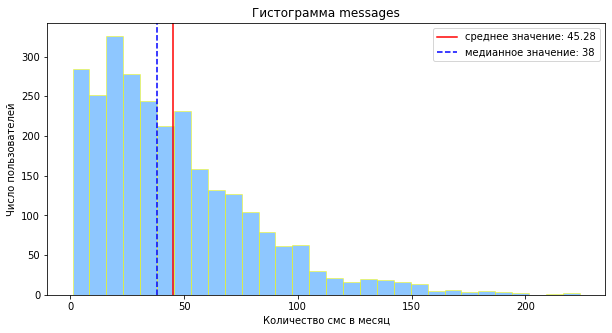

In [42]:
print(message_grouped['total_messages'].describe())
plt.figure(figsize=(10,5))
plt.hist(message_grouped['total_messages'], bins=30, color='dodgerblue', edgecolor='yellow', alpha=0.5)
plt.title("Гистограмма messages")
plt.xlabel("Количество смс в месяц")
plt.ylabel("Число пользователей")
plt.axvline(message_grouped['total_messages'].describe()['mean'], color='r', label='среднее значение: {:.2f}'.format(message_grouped['total_messages'].describe()['mean']))
plt.axvline(message_grouped['total_messages'].describe()['50%'], color='b', linestyle='dashed', label='медианное значение: {:.0f}'.format(message_grouped['total_messages'].describe()['50%']))
plt.legend()
plt.show()

#### Вывод
   - Гистограмма показывает положительную ассиметрию с длинным хвостом справа. Это означает, что больше пользователей с относительно небольшим количеством смс в месяц
   - максимальное число отрпавленных смс в месяц - 224, минимальное - 1

#### Объем израсходованного интернет-трафика с округлением по месяцам

In [43]:
internet_df_grouped = internet_df.groupby(['user_id', 'month'])['mb_used'].agg(['sum'])#.reset_index()

In [44]:
internet_df_grouped.head()

sum
user_id month          
1000    5      2253.490
        6     23233.770
        7     14003.640
        8     14055.930
        9     14568.910

In [45]:
internet_df_grouped = internet_df_grouped.fillna(0).round(2)
internet_df_grouped = internet_df_grouped.rename(columns={'sum':'mb_used_month'}).reset_index()

In [46]:
internet_df_grouped.tail(10)

,user_id,month,mb_used_month
3193,1497,11,14156.080
3194,1497,12,19918.600
3195,1498,7,7476.240
3196,1498,8,24235.210
3197,1498,9,22134.410
3198,1498,10,20579.360
3199,1499,9,1845.750
3200,1499,10,17788.510
3201,1499,11,17963.310
3202,1499,12,13055.580


#### Переведем мегабайты в гигабайты

In [47]:
internet_df_grouped['gb_used_month'] = internet_df_grouped['mb_used_month']/1024

In [48]:
#округлим гигбайты в большую сторону
internet_df_grouped['gb_used_month'] = np.ceil(internet_df_grouped['gb_used_month']).astype(int)

In [49]:
internet_df_grouped.head()

,user_id,month,mb_used_month,gb_used_month
0,1000,5,2253.490,3
1,1000,6,23233.770,23
2,1000,7,14003.640,14
3,1000,8,14055.930,14
4,1000,9,14568.910,15


#### Гистограмма internet (GB)

count   3203.000
mean      17.358
std        7.343
min        0.000
25%       13.000
50%       17.000
75%       21.000
max       49.000
Name: gb_used_month, dtype: float64


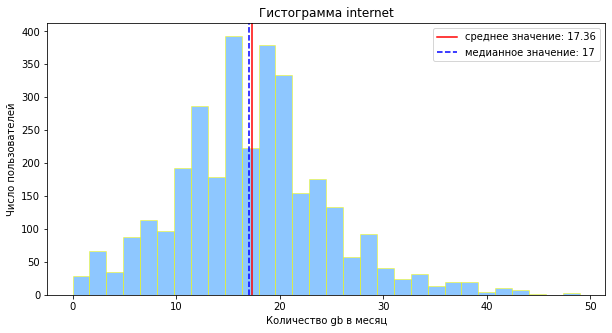

In [50]:
print(internet_df_grouped['gb_used_month'].describe())
plt.figure(figsize=(10,5))
plt.hist(internet_df_grouped['gb_used_month'], bins=30, color='dodgerblue', edgecolor='yellow', alpha=0.5)
plt.title("Гистограмма internet")
plt.xlabel("Количество gb в месяц")
plt.ylabel("Число пользователей")
plt.axvline(internet_df_grouped['gb_used_month'].describe()['mean'], color='r', label='среднее значение: {:.2f}'.format(internet_df_grouped['gb_used_month'].describe()['mean']))
plt.axvline(internet_df_grouped['gb_used_month'].describe()['50%'], color='b', linestyle='dashed', label='медианное значение: {:.0f}'.format(internet_df_grouped['gb_used_month'].describe()['50%']))
plt.legend()
plt.show()

#### Вывод
   - Медианное значение практически равно среднему, значит значения в гистограмме распределны нормально.
   - Есть пользователи, которые не пользователись интернетом. Максимальное значение по использованным гигабайтам - 49, это больше, чем предлагается в любом из двух пакетов.  

### Расчет помесячной выручки с каждого пользователя

#### Объединим полученные данные в одну таблицу

In [51]:
tariff_analysis = calls_df_grouped.merge(
    message_grouped, how='outer',on = ['user_id','month'])

tariff_analysis = tariff_analysis.merge(
    internet_df_grouped, how='outer', on=['user_id','month'])

tariff_analysis = tariff_analysis.merge(
    users_df, how='outer', on=['user_id'])

tariff_analysis = tariff_analysis.drop(
    columns='mb_used_month',axis=1)

tariff_analysis

,user_id,month,number_of_calls,duration_per_month,total_messages,gb_used_month,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_end
0,1000,5.000,22.000,159.000,22.000,3.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
1,1000,6.000,43.000,172.000,60.000,23.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
2,1000,7.000,47.000,340.000,75.000,14.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
3,1000,8.000,52.000,408.000,81.000,14.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
4,1000,9.000,58.000,466.000,57.000,15.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1328,11.000,NaN,NaN,8.000,35.000,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,10,NaN
3212,1328,12.000,NaN,NaN,7.000,39.000,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,10,NaN
3213,1328,10.000,NaN,NaN,6.000,22.000,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,10,NaN
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,12.000


#### Заполним пропуски

In [52]:
tariff_analysis.isna().sum()

user_id                  0
month                    2
number_of_calls         42
duration_per_month      42
total_messages         499
gb_used_month           13
age                      0
churn_date            3027
city                     0
first_name               0
last_name                0
reg_date                 0
tariff                   0
month_start              0
month_end             3027
dtype: int64

In [53]:
tariff_analysis['number_of_calls']=tariff_analysis['number_of_calls'].fillna(0)
tariff_analysis['duration_per_month']=tariff_analysis['duration_per_month'].fillna(0)
tariff_analysis['total_messages']=tariff_analysis['total_messages'].fillna(0)
tariff_analysis['gb_used_month']=tariff_analysis['gb_used_month'].fillna(0)

In [54]:
tariff_analysis.isna().sum()

user_id                  0
month                    2
number_of_calls          0
duration_per_month       0
total_messages           0
gb_used_month            0
age                      0
churn_date            3027
city                     0
first_name               0
last_name                0
reg_date                 0
tariff                   0
month_start              0
month_end             3027
dtype: int64

#### Выручка в месяц по каждому пользователю

Найдём помесячную выручку с каждого пользователявычтите, для этого бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану

In [55]:
#функция для подсчета выручки



def tariff_profit (row):
    smart = 550
    ultra = 1950
    if row['tariff'] == 'ultra':
        if row['duration_per_month'] > 3000:
            row['duration_per_month'] = (row['duration_per_month']-3000) * 1
        else:
            row['duration_per_month'] = 0
            
        if row['total_messages'] > 1000:
            row['total_messages'] = (row['total_messages']-1000) * 1
        else:
            row['total_messages'] = 0
            
        if row['gb_used_month'] > 30:
            row['gb_used_month'] = (row['gb_used_month']-30) * 150
        else:
            row['gb_used_month'] = 0
        if row['month_start'] == row['month_end']:
            ultra = 0
        return ultra + row['duration_per_month'] + row['total_messages'] + row['gb_used_month']
       
    
    if row['tariff'] == 'smart':
        if row['duration_per_month'] > 500:
            row['duration_per_month'] = (row['duration_per_month']-500) * 3
        else:
            row['duration_per_month'] = 0
            
        if row['total_messages'] > 50:
            row['total_messages'] = (row['total_messages']-50) * 3
        else:
            row['total_messages'] = 0
            
        if row['gb_used_month'] > 15:
            row['gb_used_month'] = (row['gb_used_month']-15) * 200
        else:
            row['gb_used_month'] = 0
            
        if row['month_start'] == row['month_end']:
            smart = 0
        return smart + row['duration_per_month'] + row['total_messages'] + row['gb_used_month']

In [56]:
tariff_analysis['tariff_profit'] = tariff_analysis.apply(tariff_profit,axis=1)
tariff_analysis.head()

,user_id,month,number_of_calls,duration_per_month,total_messages,gb_used_month,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_end,tariff_profit
0,1000,5.000,22.000,159.000,22.000,3.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN,1950.000
1,1000,6.000,43.000,172.000,60.000,23.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN,1950.000
2,1000,7.000,47.000,340.000,75.000,14.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN,1950.000
3,1000,8.000,52.000,408.000,81.000,14.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN,1950.000
4,1000,9.000,58.000,466.000,57.000,15.000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN,1950.000


In [57]:
tariff_analysis.query('gb_used_month>30')

,user_id,month,number_of_calls,duration_per_month,total_messages,gb_used_month,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_end,tariff_profit
159,1024,11.000,157.000,1146.000,0.000,43.000,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,10,NaN,3900.000
160,1024,12.000,136.000,949.000,0.000,36.000,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,10,NaN,2850.000
260,1042,12.000,121.000,728.000,75.000,37.000,42,NaT,Хабаровск,Константин,Добрынин,2018-11-25,smart,11,NaN,5709.000
311,1050,7.000,35.000,209.000,52.000,35.000,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,6,10.000,2700.000
382,1060,12.000,184.000,1233.000,52.000,43.000,46,NaT,Калуга,Яков,Рудаков,2018-11-24,ultra,11,NaN,3900.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,1231,9.000,0.000,0.000,188.000,33.000,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5,NaN,2400.000
3180,1231,10.000,0.000,0.000,185.000,31.000,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5,NaN,2100.000
3181,1231,8.000,0.000,0.000,180.000,32.000,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,5,NaN,2250.000
3211,1328,11.000,0.000,0.000,8.000,35.000,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,10,NaN,2700.000


Проверим пользователей, который пользовались тарифом до месяца

In [58]:
tariff_analysis.query('month_start==month_end')

,user_id,month,number_of_calls,duration_per_month,total_messages,gb_used_month,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_end,tariff_profit
3214,1128,NaN,0.000,0.000,0.000,0.000,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,12.000,0.000
3215,1371,NaN,0.000,0.000,0.000,0.000,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12,12.000,0.000


In [59]:
users_df.query('user_id==1128 or user_id == 1371')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_end
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12,12.000
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12,12.000


Эти кленты не стали пользоваться услугами связи и расторгли договор до начсиления абонентской платы.

#### Найдём средние показатели в месяц по каждому пользователю

In [60]:
average_profit = tariff_analysis.groupby('user_id').agg({'month': ['min','max'],'tariff_profit':'sum','number_of_calls':'sum','duration_per_month':'sum','total_messages':'sum','gb_used_month':'sum'}).reset_index()
average_profit.sample(5)

user_id month        tariff_profit number_of_calls duration_per_month  \
              min    max           sum             sum                sum   
356    1356 4.000 12.000     22500.000        1026.000           7293.000   
227    1227 1.000 12.000     26179.000        1008.000           7364.000   
130    1130 4.000 12.000     11901.000         657.000           4640.000   
449    1449 7.000 12.000      6597.000         462.000           3199.000   
116    1116 4.000 12.000      6150.000         405.000           2802.000   

    total_messages gb_used_month  
               sum           sum  
356       1224.000       283.000  
227        336.000       257.000  
130        558.000       162.000  
449        540.000        82.000  
116          0.000       127.000

In [61]:
average_profit.columns=('user_id', 'start', 'end', 'total_profit', 'total_number_calls','total_min','total_sms', 'total_gb')
average_profit.sample(5)

,user_id,start,end,total_profit,total_number_calls,total_min,total_sms,total_gb
148,1148,4.000,12.000,22650.000,945.000,6740.000,126.000,295.000
256,1256,9.000,12.000,7248.000,256.000,1851.000,292.000,66.000
391,1391,5.000,12.000,16350.000,816.000,6025.000,24.000,192.000
23,1023,10.000,12.000,4857.000,177.000,1225.000,111.000,52.000
420,1420,9.000,12.000,9800.000,108.000,723.000,44.000,95.000


Добавим в таблицу со средними показателями инфо по пользователям

In [62]:
average_profit = average_profit.merge(users_df, how='left', on=['user_id'])
average_profit.sample(5)

,user_id,start,end,total_profit,total_number_calls,total_min,total_sms,total_gb,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_end
378,1378,1.000,12.000,7287.000,852.000,5660.000,144.000,148.000,21,NaT,Иркутск,Евгения,Бычкова,2018-01-19,smart,1,NaN
494,1494,8.000,12.000,4953.000,275.000,1946.000,0.000,78.000,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,8,NaN
357,1357,9.000,12.000,5200.000,196.000,1482.000,164.000,75.000,37,NaT,Томск,Касьян,Ермилов,2018-09-02,smart,9,NaN
451,1451,8.000,12.000,7853.000,500.000,3613.000,190.000,59.000,58,NaT,Набережные Челны,Виктория,Завьялова,2018-08-27,smart,8,NaN
171,1171,3.000,12.000,10308.000,820.000,5996.000,660.000,130.000,47,NaT,Москва,Каролина,Иванова,2018-03-20,smart,3,NaN


In [63]:
average_profit=average_profit[['user_id','start','end','total_profit','total_number_calls','total_min','total_sms','total_gb','city','tariff']]
average_profit.sample(5)

,user_id,start,end,total_profit,total_number_calls,total_min,total_sms,total_gb,city,tariff
431,1431,3.000,12.000,12842.000,340.000,2446.000,810.000,178.000,Уфа,smart
23,1023,10.000,12.000,4857.000,177.000,1225.000,111.000,52.000,Томск,smart
32,1032,1.000,12.000,17920.000,768.000,5318.000,420.000,234.000,Ульяновск,smart
94,1094,5.000,12.000,15600.000,792.000,5368.000,168.000,144.000,Новосибирск,ultra
128,1128,NaN,NaN,0.000,0.000,0.000,0.000,0.000,Волжский,ultra


### Анализ данных

#### Сравнение тарифов

In [64]:
#функция для построения графика для оценки поведения пользователей тарифов
def hist_and_stat(df, name,x_smart,x_ultra):
    cd = df.groupby(df.tariff)[name]
    cd_desc = cd.describe(percentiles = [.01,.25,.75,.99])
    cd_desc['var']= [np.var(cd.get_group('smart'), ddof=1), np.var(cd.get_group('ultra'), ddof=1)]
    display(cd_desc)
    smart = df.query('tariff == "smart"')[name]
    ultra = df.query('tariff == "ultra"')[name]
    plt.figure(figsize=(10,6))
    plt.hist(smart, bins=50, color='dodgerblue', edgecolor='grey', alpha=0.5, label = 'smart', density = False)
    plt.hist(ultra, bins=50, color='yellow', edgecolor='grey', alpha=0.5,label = 'ultra', density = False)
    plt.axvline(cd_desc['mean'][0], color='blue', linestyle='dashed', linewidth=3, label='Среднее smart: {:.2f}'.format(cd_desc['mean'][0]))
    
    plt.axvline(cd_desc['mean'][1], color='orange', linestyle='dashed', linewidth=3, label='Среднее ultra: {:.2f}'.format(cd_desc['mean'][1]))

    plt.axvline(x_smart, color='blue', linestyle='solid', linewidth=3, label='Включено в пакет smart')
    plt.axvline(x_ultra, color='orange', linestyle='solid', linewidth=3, label='Включено в пакет ultra')
    plt.legend()
    plt.title('Гистограмма {}'.format(name))

#### Сравнение длины звонков Ultra и Smart

Сравнение ULTRA И SMART


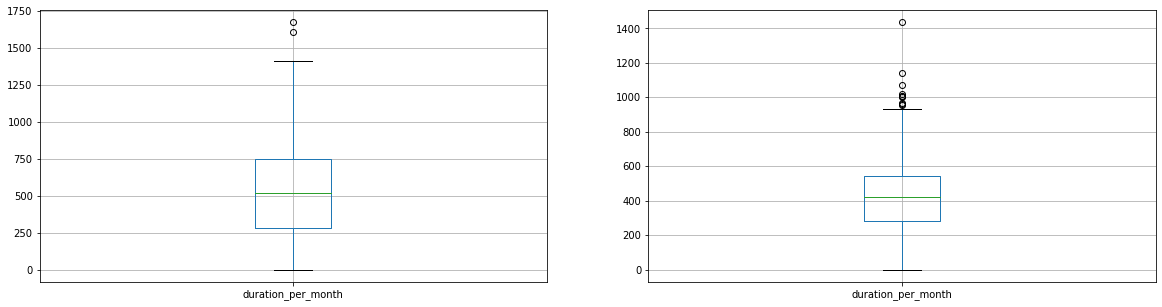

In [65]:
print('Сравнение ULTRA И SMART')
fig = plt.figure(figsize = (20,5))
tariff_analysis[tariff_analysis['tariff'] == 'ultra'].boxplot('duration_per_month', ax = plt.subplot(1,2,1))
tariff_analysis[tariff_analysis['tariff'] == 'smart'].boxplot('duration_per_month', ax = plt.subplot(1,2,2));

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.000,417.748,190.477,0.000,13.580,282.000,421.500,545.000,872.710,1435.000,36281.394
ultra,986.000,526.089,317.888,0.000,0.000,282.500,518.000,751.750,1291.050,1673.000,101052.494


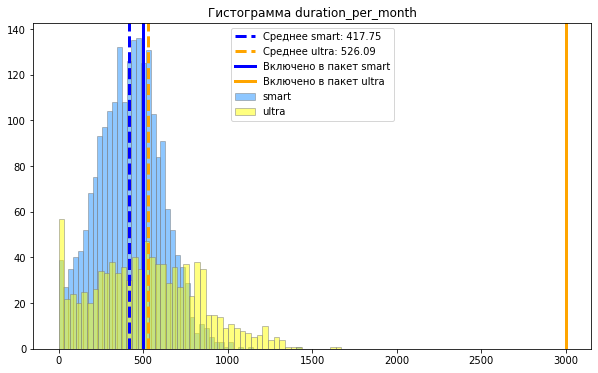

In [66]:
hist_and_stat(tariff_analysis,'duration_per_month',500,3000)

#### Вывод
   - Пользователи тарифа ultra в среднем в месяц тратят больше минут разговора, чем пользователи тарифа smart.
   - На тарифе smart пользователи часто не укладываются в лимиты и доплачивают за звонки.
   - Дисперсия и стандартное отклонение выше на тарифе ultra, но пользователи этого тарифа всегда укладываются в установленные лимиты. Максимальное число минут разговора в месяц значительно меньше заложенных в него 3000.
   - На тарифе ultra больше пользователей, которые не тратят минуты

#### Сравнение количества смс

Сравнение ULTRA И SMART


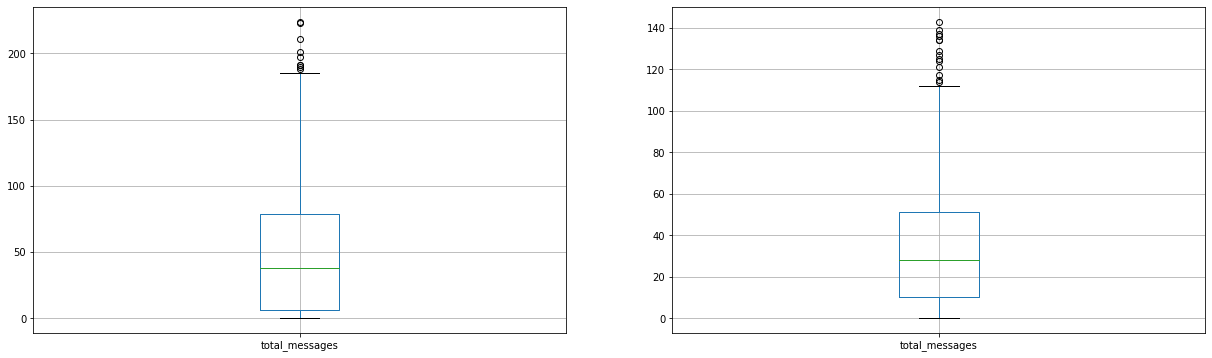

In [67]:
print('Сравнение ULTRA И SMART')
fig = plt.figure(figsize = (21,6))
tariff_analysis[tariff_analysis['tariff'] == 'ultra'].boxplot('total_messages', ax = plt.subplot(1,2,1))
tariff_analysis[tariff_analysis['tariff'] == 'smart'].boxplot('total_messages', ax = plt.subplot(1,2,2));

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.000,33.369,28.230,0.000,0.000,10.000,28.000,51.000,108.000,143.000,796.955
ultra,986.000,49.313,47.806,0.000,0.000,6.000,38.000,78.750,183.300,224.000,2285.417


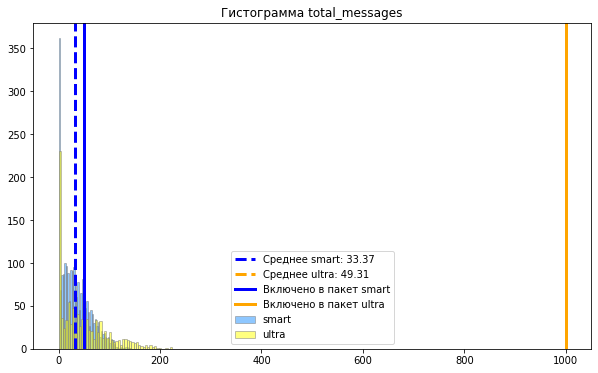

In [68]:
hist_and_stat(tariff_analysis,'total_messages',50,1000)

#### Вывод
   - Пользователи тарифа ultra в среднем в месяц тратят больше смс, чем пользователи тарифа smart.
   - На тарифе smart пользователи также не укладываются в лимиты и доплачивают за смс.
   - Дисперсия и стандартное отклонение выше на тарифе ultra, но пользователи этого тарифа всегда укладываются в установленные лимиты. Максимальное число смс в месяц значительно меньше заложенных в него 1000.
   - На тарифе smart больше пользователей, которые не тратят смс

#### Сравнение потраченных GB

Сравнение ULTRA И SMART


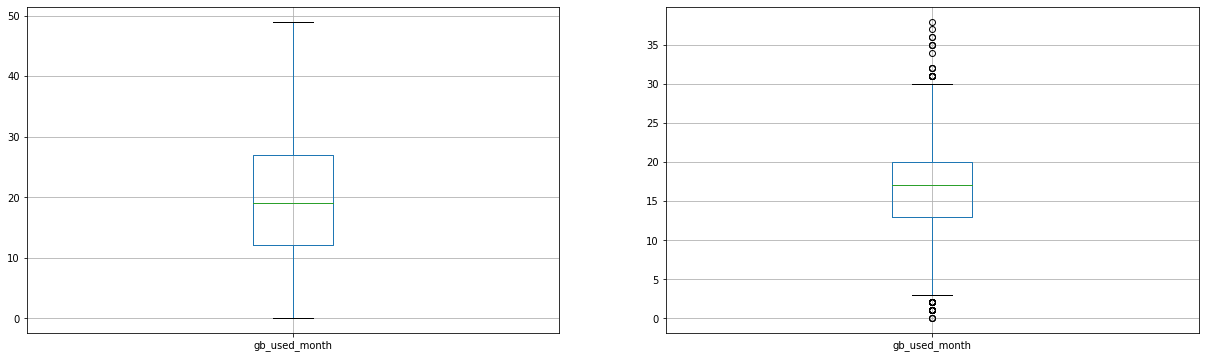

In [69]:
print('Сравнение ULTRA И SMART')
fig = plt.figure(figsize = (21,6))
tariff_analysis[tariff_analysis['tariff'] == 'ultra'].boxplot('gb_used_month', ax = plt.subplot(1,2,1))
tariff_analysis[tariff_analysis['tariff'] == 'smart'].boxplot('gb_used_month', ax = plt.subplot(1,2,2));

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.000,16.322,5.756,0.000,2.000,13.000,17.000,20.000,29.710,38.000,33.133
ultra,986.000,19.475,9.868,0.000,0.000,12.000,19.000,27.000,42.150,49.000,97.379


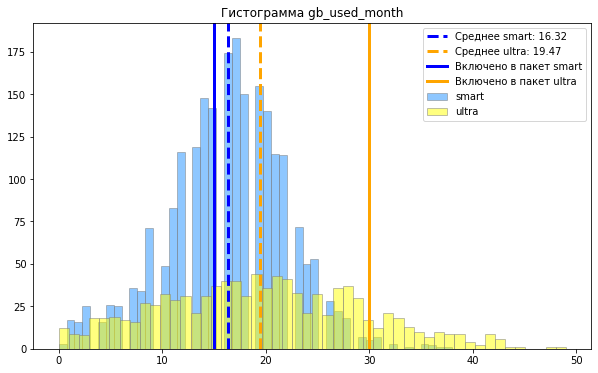

In [70]:
hist_and_stat(tariff_analysis,'gb_used_month',15,30)

#### Вывод
   - Пользователи тарифа ultra в среднем в месяц тратят больше GB, чем пользователи тарифа smart.
   - На тарифе smart в среднем пользователи тратят часто больше, чем предоставляется в бесплатном пакете и доплачивают за GB.
   - Пользователи тарифа ultra также не укладываются, но реже, траты выше 30GB в месяц аномальны. Максимум почти доходит до 50 GB в месяц.
   - Дисперсия и стандартное отклонение выше на тарифе ultra

####  Сравнение прибыли

Сравнение ULTRA И SMART


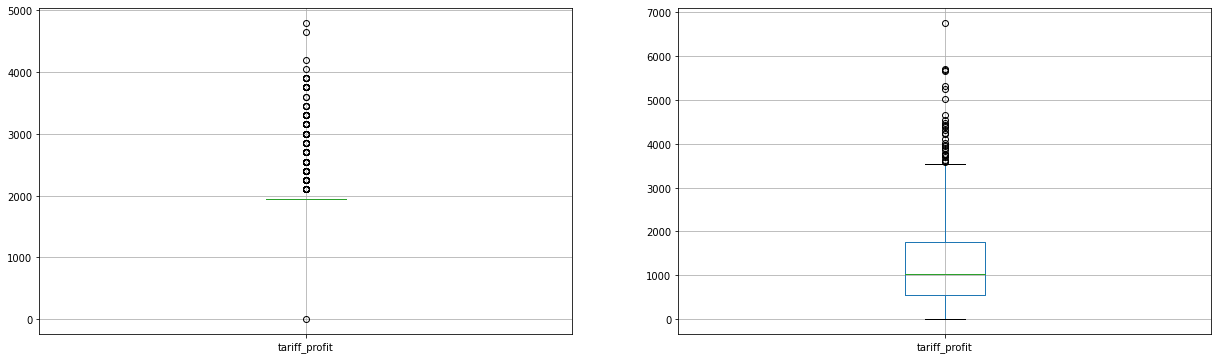

In [71]:
print('Сравнение ULTRA И SMART')
fig = plt.figure(figsize = (21,6))
tariff_analysis[tariff_analysis['tariff'] == 'ultra'].boxplot('tariff_profit', ax = plt.subplot(1,2,1))
tariff_analysis[tariff_analysis['tariff'] == 'smart'].boxplot('tariff_profit', ax = plt.subplot(1,2,2));

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2230.000,1289.395,818.677,0.000,550.000,550.000,1021.000,1750.000,3773.710,6770.000,670231.423
ultra,986.000,2068.053,381.732,0.000,1950.000,1950.000,1950.000,1950.000,3772.500,4800.000,145719.453


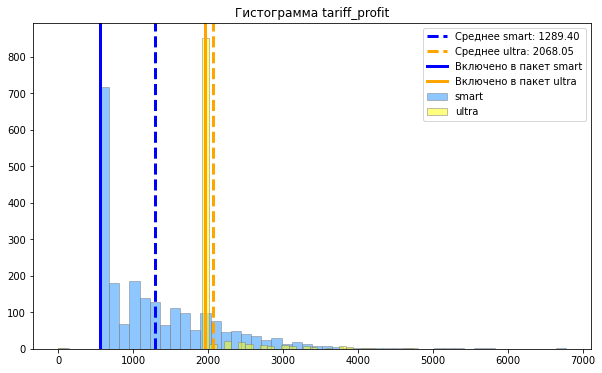

In [72]:
hist_and_stat(tariff_analysis,'tariff_profit',550,1950)

#### Вывод
   - Пользователи тарифа ultra в среднем в месяц приносят на 60% больше прибыли, чем пользователи тарифа smart.
   - На тарифе smart в среднем пользователи всегда доплачивают сверх ежемесячной платы.
   - Пользователи тарифа ultra в ежемесячный платеж часто не укладываются из-за потраченных гигабайтов.
   - Дисперсия и стандартное отклонение выше на тарифе smart

####  Сравнение Москвы и других городов

Сравнение Москва и другие города


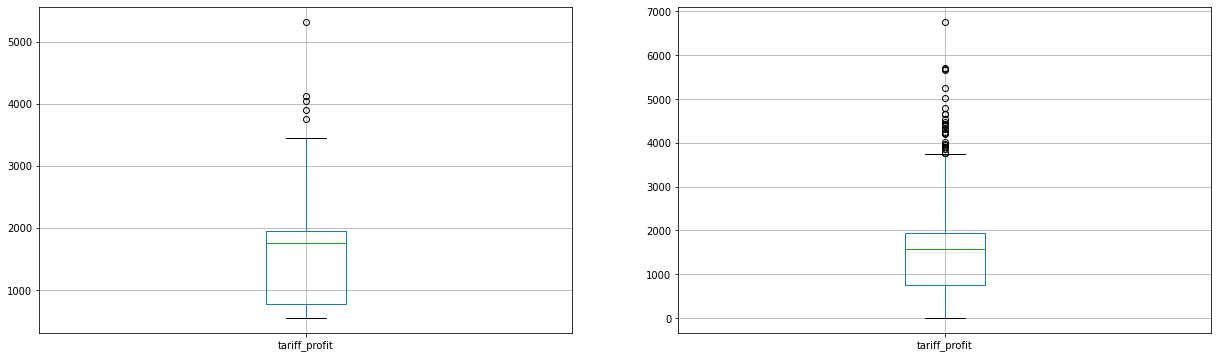

In [73]:
print('Сравнение Москва и другие города')
fig = plt.figure(figsize = (21,6))
tariff_analysis[tariff_analysis['city'] == 'Москва'].boxplot('tariff_profit', ax = plt.subplot(1,2,1))
tariff_analysis[tariff_analysis['city'] != 'Москва'].boxplot('tariff_profit', ax = plt.subplot(1,2,2));

In [74]:
#функция, которая категоризирует все города по принципу Мсоква - не Москва
def city_type(row):
    city = row['city']
    
    
    if city == 'Москва':
        return 'Москва'
    else:
        return 'Другой'

In [75]:
tariff_analysis['city_type'] = tariff_analysis.apply(city_type, axis=1)
tariff_analysis.sample(5)

,user_id,month,number_of_calls,duration_per_month,total_messages,gb_used_month,age,churn_date,city,first_name,last_name,reg_date,tariff,month_start,month_end,tariff_profit,city_type
1993,1318,10.000,90.000,538.000,54.000,16.000,53,NaT,Курган,Марьяна,Анищенко,2018-03-22,ultra,3,NaN,1950.000,Другой
1362,1217,9.000,72.000,418.000,68.000,16.000,42,NaT,Ульяновск,Ермолай,Сазонов,2018-02-23,smart,2,NaN,804.000,Другой
1017,1164,10.000,46.000,353.000,35.000,12.000,49,NaT,Магнитогорск,Геральд,Лебедев,2018-04-03,smart,4,NaN,550.000,Другой
2909,1457,4.000,70.000,441.000,33.000,19.000,35,NaT,Саратов,Татьяна,Авчинникова,2018-03-14,smart,3,NaN,1350.000,Другой
2921,1458,6.000,100.000,781.000,4.000,12.000,36,NaT,Барнаул,Роберт,Азаров,2018-02-13,ultra,2,NaN,1950.000,Другой


Посчитаем среднее количество, дисперсию и стандартное отклонение

In [76]:
    cd = tariff_analysis.groupby(tariff_analysis.city_type)['tariff_profit']
    cd_desc = cd.describe(percentiles = [.01,.25,.75,.99])
    cd_desc['var']= [np.var(cd.get_group('Другой'), ddof=1), np.var(cd.get_group('Москва'), ddof=1)]
    display(cd_desc)

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
city_type,,,,,,,,,,,
Другой,2605.000,1523.765,809.580,0.000,550.000,750.000,1580.000,1950.000,3898.800,6770.000,655419.892
Москва,611.000,1546.714,752.088,550.000,550.000,780.500,1750.000,1950.000,3375.000,5321.000,565636.467


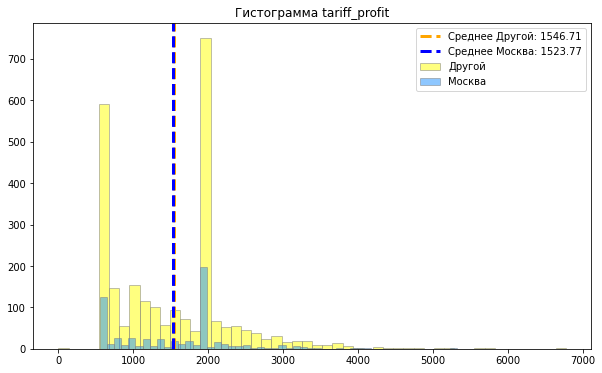

In [77]:
    Москва = tariff_analysis.query('city_type == "Москва"')['tariff_profit']
    Другой = tariff_analysis.query('city_type == "Другой"')['tariff_profit']
    plt.figure(figsize=(10,6))
    
    plt.hist(Другой, bins=50, color='yellow', edgecolor='grey', alpha=0.5,label = 'Другой', density = False)
    plt.hist(Москва, bins=50, color='dodgerblue', edgecolor='grey', alpha=0.5, label = 'Москва', density = False)
    
    plt.axvline(cd_desc['mean'][1], color='orange', linestyle='dashed', linewidth=3, label='Среднее Другой: {:.2f}'.format(cd_desc['mean'][1]))
    plt.axvline(cd_desc['mean'][0], color='blue', linestyle='dashed', linewidth=3, label='Среднее Москва: {:.2f}'.format(cd_desc['mean'][0]))
    
    plt.legend()
    plt.title('Гистограмма {}'.format('tariff_profit'))
    plt.show()

#### Вывод

   - Пользователи из Москвы и других городов в среднем в месяц приносят равную прибыль.
   - Дисперсия и стандартное отклоеннеи выше у пользователей из Москвы


### Проверьте гипотезы

Проверим следующие гипотезы:

   - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
   - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Н0 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» **равны**, т.е. средние значения равны.

Н1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» **не равны**, т.е. средние значения не равны.

Дисперсии выборок были расчитаны выше, они отличаются более чем на 5%

In [78]:
sample_1 = tariff_analysis[tariff_analysis['tariff'] == 'ultra']['tariff_profit'] 
sample_2 = tariff_analysis[tariff_analysis['tariff'] == 'smart']['tariff_profit'] 
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу нельзя')

p-значение:  1.0060103384113545e-159
Отвергаем нулевую гипотезу


#### Вывод
p-значение слишком мало, что дает нам возможность отвергнуть гипотезу об отсутствии различий между выручками на тарифах, то есть случайность результатов теста маловероятна

Н0 - Средняя выручка пользователей из Москвы и других регионов **равны**, т.е. средние значения равны.

Н1 - Средняя выручка пользователей из Москвы и других регионов **не равны**, т.е. средние значения не равны.

Дисперсии выборок были расчитаны выше, они отличаются более чем на 5%

In [79]:
sample_1 = tariff_analysis[tariff_analysis['city'] == 'Москва']['tariff_profit'] 
sample_2 = tariff_analysis[tariff_analysis['city'] != 'Москва']['tariff_profit'] 
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу нельзя')

p-значение:  0.5228938337114026
Отвергнуть нулевую гипотезу нельзя


p-значение больше порогового, значит мы не сможем опровергнуть гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Общий вывод

Мы проанализировали поведение пользователей на двух тарифах федерального опреатора сотовой связи пришли к выводу, что:
    
    - Пользователи тарифа ultra в среднем в месяц приносят на 60% больше прибыли, чем пользователи тарифа smart.
    - Однако пользователи этого тарифа никогда не превышают порог по использлванным минутам и сообщениям.
    - Зато пользователи ultra регулярно тратят больше GB, чем заложено в ежемесячный тариф. 
    - На тарифе smart пользователи в среднем не укладываются в ежемесячный платеж переплачивая за каждую слугу - и звонки и смс и GB
    - Пользователи из Москвы не приносят больше прибыли, чем пользователи из других говородов. Однако каждый москвич платит минимум по 550 р в месяц.

**Какой тариф лучше?:**

    - Среднее на пользователя в месяц нам показывает, что тариф Ultra приносит компании больше денег в пересчете на вложенные ресурсы. Т.е. предоставили услуг меньше, а получили больше.
    - Однако тариф smart популярнее, больше пользователей используют именно его, общая выручка тарифа выше. 
    - Ultra может понравиться бизнесменам из-за дорогого, но широкого пакета звонков и смс. 
    
**Рекомендации:**

    - Уменьшить порог по минутам и сообщениям на ultra, а для smart увеличить
    - увеличить порог по GB для ultra и smart
    - Два пользователя расторгли договор меньше чем через месяц, надо проверить и получить обратную связь.
    - В датасете `calls_df` Есть несколько пиков на 5, 10, 15 и 20 минутах, нужно уточнить, с чем связаны эти всплески
    - Сделать рекламу ultra в сегменте vip и business
    - Продвигать тариф smart средиобычных пользователей
    